In [ ]:
from torchvision.io import read_image
from torchvision.models import resnet18, ResNet18_Weights

import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
#%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset = ImageFolder("/content/drive/MyDrive/DBIsubset")


Mounted at /content/drive


In [ ]:
#len(dataset)
#len(dataset.classes)
for n in dataset.classes:
  print(n)
print(dataset.classes[1])
len(dataset)



3
golden_retriever


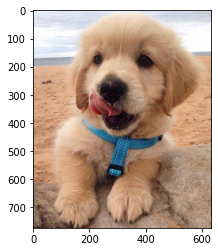

In [ ]:
"Split Data 3 datasets i.e.train: 60%. validation 10%, test: 30%"
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

img, label = train_ds[6]
print(label)
print(dataset.classes[label])
plt.imshow(img)




In [ ]:
# Create custom dataset class
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

Image Preprocoessing which consists of resizing images to 224x224, random cropping, random horizontal flipping, and random rotations for augmentation

3
golden_retriever


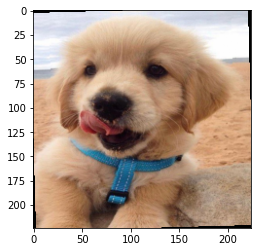

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True) not neccessary for input images
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])


train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

img, label = train_dataset[6]
print(label)
print(dataset.classes[label])
plt.imshow(img.permute(1,2,0))

In [ ]:
batch_size = 64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
# def show_batch(dl):
#     for img, lb in dl:
#         fig, ax = plt.subplots(figsize=(16, 8))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
#         break

# show_batch(train_dl)

Network Architecture

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:

class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        #loss = F.nll_loss(out, targets)
        criterion = nn.CrossEntropyLoss() #NEW
        loss = criterion(out, targets) # NEW
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        #loss = F.nll_loss(out, targets)
        criterion = nn.CrossEntropyLoss() #NEW
        loss = criterion(out, targets) #NEW
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, train_acc: {:.4f}, test_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"], result["train_acc"], result["test_acc"]))
        

In [ ]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),   # 224 * 244 * 16 channels
            nn.BatchNorm2d(16),   
            nn.ReLU(),
                                            
            nn.Conv2d(16, 16, 3, stride=1, padding=1), # 244 *244 * 16 channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 16
            
            nn.Conv2d(16, 32, 3, stride=1, padding=1),   # 112 * 112* 32
            nn.BatchNorm2d(32),
            nn.ReLU(), 

            nn.Conv2d(32, 64, 3, stride=1, padding=1),    # 112 * 112* 64
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 64

            nn.Dropout(p=0.5, inplace=False),         # remove for non-dropout
            
            nn.Flatten(),
            nn.Linear(56*56*64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(32, 7),
            nn.LogSoftmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)

model = DogBreedClassificationCNN()
model

In [ ]:
# TASK 3
class DogBreedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

model2 = DogBreedResnet18()
model2

TASK 4 ONLY

In [ ]:
class DogBreedPreTrainedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)

         # Freeze early layers
        for param in self.network.parameters():
            param.requires_grad = False
        n_inputs = self.network.fc.in_features

        # Add on classifier
        self.network.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 7), nn.LogSoftmax(dim=1))
        
    def forward(self, xb):
        return self.network(xb)

model3 = DogBreedPreTrainedResnet18()
model3

In [ ]:
class DogBreedPreTrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)

         # Freeze early layers
        for param in self.network.parameters():
            param.requires_grad = False
        n_inputs = self.network.fc.in_features

        # Add on classifier
        self.network.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 7), nn.LogSoftmax(dim=1))
        
    def forward(self, xb):
        return self.network(xb)

model4 = DogBreedPreTrainedResnet34()
model4

In [ ]:
class DogBreedPreTrainedResneXt32(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnext50_32x4d(pretrained=True)

         # Freeze early layers
        for param in self.network.parameters():
            param.requires_grad = False
        n_inputs = self.network.fc.in_features

        # Add on classifier
        self.network.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 7), nn.LogSoftmax(dim=1))
        
    def forward(self, xb):
        return self.network(xb)

model5 = DogBreedPreTrainedResneXt32()
model5

Moving Data to GPU


In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)
            
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val and test dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device) #NEW


# moving model to gpu
to_device(model, device); # change model here

cuda


In [ ]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model2(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

TRAINING.  I have used train_one_cycle instead of using a fixed learning rate, uses a learning rate scheduler, which will change the learning rate after every batch of training.

In [ ]:
from tqdm.notebook import tqdm

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader): # NEW
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase + getting acurracies 
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        training_result = evaluate(model, train_loader) # NEW
        result['train_acc'] = training_result['val_acc']
        testing_result = evaluate(model, test_loader) #new
        result['test_acc'] = testing_result['val_acc'] #new
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

history = fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func) # change model
history[0].keys()

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)

result = evaluate(model, test_dl) # Report Test Accuracy
result

PLOT Training, Validation and Test Accuracies over all epochs

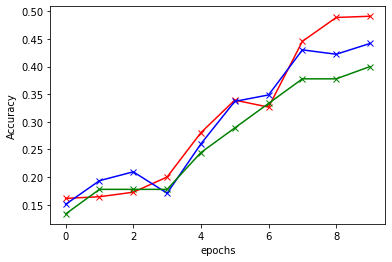

In [ ]:
train_acc = []
test_acc = []
val_acc = []
time = list(range(len(history)))
for h in history:
    train_acc.append(h['train_acc'])
    test_acc.append(h['test_acc'])
    val_acc.append(h['val_acc'])

plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.plot(time, test_acc, c='blue', label='test_acc', marker='x')
plt.plot(time, val_acc, c='green', label='val_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

TASK 3 B and Task 4. Evaluating any model on the SDD set.

In [ ]:
dataset2 =  ImageFolder("/content/drive/MyDrive/SDDsubset")
len(dataset2.classes)

sdd_dataset = DogBreedDataset(dataset2, test_transform)
sdd_dl = DataLoader(sdd_dataset, batch_size*2, num_workers=2, pin_memory=True)
sdd_dl = DeviceDataLoader(sdd_dl, device)

result = evaluate(model5, sdd_dl) #change model here


In [ ]:
result